In [32]:
%matplotlib inline
import Queue as queue
from collections import defaultdict 
# from __future__ import print_function
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import copy
import operator
import numpy as np

In [105]:
M = 6
N = 9
LEFT = (0, -1)
RIGHT = (0, 1)
UP = (-1, 0)
DOWN = (1, 0)
ACTIONS = [LEFT, RIGHT, UP, DOWN]
START_STATE = (3, 1)
GOAL_STATE = (1, N)
# State Table 
Q = defaultdict(dict)
# Model = defaultdict(dict)
Model = {}
OBSTACLE_REWARD = -20
# Epsilon Value for e-greedy policy 
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 0.95
NO_OF_EPISODES = 50
NO_OF_STEPS = 100
OBSTACLES = set([(2,3),(3,3),(4,3),(5,6),(8,1),(8,2),(8,3)])
THRESHOLD = 0.05

In [47]:
def is_valid_state((i, j)):
    if i > M or j > N or i < 1 or j < 1:
        return False
    return True
def is_goal_state((i,j)):
    if i == GOAL_STATE[0] and j == GOAL_STATE[1]:
        return True
    return False
def is_obstacle_state((i,j)):
    state = (i,j)
    if state in OBSTACLES:
        return True
    return False
def is_terminal_state((i,j)):
    return is_obstacle_state((i,j)) or is_goal_state((i,j))

In [48]:
def init_Q():
    Model = {}
    for i in range(1, M+1):
        for j in range(1, N+1):
            for action in ACTIONS:
                next_state = tuple(map(operator.add, (i,j), action))
                if is_valid_state(next_state):
                    Q[(i,j)][action] = 0

In [109]:
def set_maze_world(m, n, obstacle_states, start_state, goal_state):
    M = m
    N = n
    OBSTACLES = obstacle_states
    START_STATE = start_state
    GOAL_STATE = goal_state

In [49]:
def epsilon_greedy((i,j)):
    state = (i,j)
    valid_actions = Q[state].keys()
    max_action = max(Q[state], key=Q[state].get)
    if random.random() < EPSILON:
        random_action = random.choice(valid_actions)
        return random_action
    max_action = max(Q[state], key=Q[state].get)
    return max_action

In [50]:
def take_action(S, A):
    next_state = tuple(map(operator.add, S, A))
    if is_goal_state(next_state):
        reward = 1
    else:
        reward = 0
    if is_obstacle_state(next_state) or not is_valid_state(next_state):
        next_state = S
    return next_state, reward

In [101]:
def dyna(no_planning_steps):
    init_Q()
    total_steps = []
    for i in range(NO_OF_EPISODES):
        S = START_STATE
        episode_steps = 0
        while not is_terminal_state(S):
            episode_steps += 1
            A = epsilon_greedy(S)
            S_next, reward = take_action(S, A)
            A_next = max(Q[S_next], key=Q[S_next].get)
            Q[S][A] = Q[S][A] + ALPHA * (reward + GAMMA*Q[S_next][A_next] - Q[S][A])
            Model[(S,A)] = (reward, S_next)
            S_new = S_next
            for i in range(no_planning_steps):
                (S,A) = random.choice(Model.keys())
                (reward, S_next) = Model[(S,A)]
                A_next = max(Q[S_next], key=Q[S_next].get)
                Q[S][A] = Q[S][A] + ALPHA*(reward + GAMMA*Q[S_next][A_next] - Q[S][A])
#             if (episode_steps % 100 == 0):
#                 print(episode_steps)
            S = S_new
        total_steps.append(episode_steps)
    return total_steps

def prioritized_sweeping(no_planning_steps):
    init_Q()
    p_queue = queue.PriorityQueue()
    total_steps = []
    for i in range(NO_OF_EPISODES):
        S = START_STATE
        episode_steps = 0
        while not is_terminal_state(S):
            episode_steps += 1
            A = epsilon_greedy(S)
            S_next, reward = take_action(S, A)
            A_max = max(Q[S_next], key=Q[S_next].get)
            Model[(S,A)] = (reward, S_next)
            priority = abs(reward + GAMMA*Q[S_next][A_max] - Q[S][A])
            if priority >= THRESHOLD:
                p_queue.put((-priority, S, A))
            S_new = S_next
            for j in range(no_planning_steps):
                if p_queue.empty():
                    break
                (_, S, A) = p_queue.get()
                R, S_next = Model[(S,A)] 
                A_next = max(Q[S_next], key=Q[S_next].get)
                Q[S][A] = Q[S][A] + ALPHA*(R + GAMMA*Q[S_next][A_next] - Q[S][A])
                # Get all entires in model S_ and A_ has S is on right hand side
                for entry in Model:
                    if Model[entry][1] == S:
                        R_p = Model[entry][0]
                        A_next = max(Q[S], key=Q[S].get)
                        priority = abs(R_p + GAMMA*Q[S][A_next] - Q[entry[0]][entry[1]])
                        if priority >= THRESHOLD:
                            p_queue.put((-priority, entry[0], entry[1]))
            S = S_new
        total_steps.append(episode_steps)
    return total_steps

Done With Dyna 0
Done With Dyna 5
Done With Dyna 50


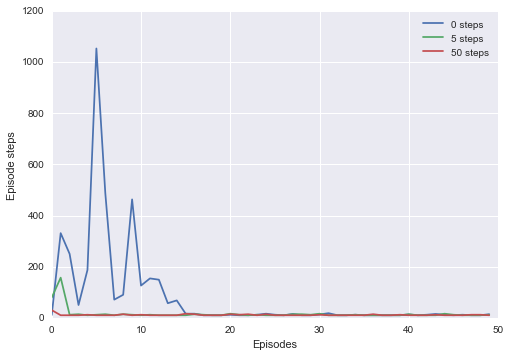

In [86]:
total_steps_0 = []
total_steps_5 = []
total_steps_50 = []
total_steps_0 = dyna(0)
print('Done With Dyna 0')
total_steps_5 = dyna(5)
print('Done With Dyna 5')
total_steps_50 = dyna(50)
print('Done With Dyna 50')

plt.plot(range(NO_OF_EPISODES), total_steps_0, range(NO_OF_EPISODES), total_steps_5, range(NO_OF_EPISODES), total_steps_50)
plt.ylabel('Episode steps')
plt.xlabel('Episodes')
plt.legend(['0 steps', '5 steps', '50 steps'], loc='best')

Done With prioritized_sweeping 0
Done With prioritized_sweeping 5
Done With prioritized_sweeping 50


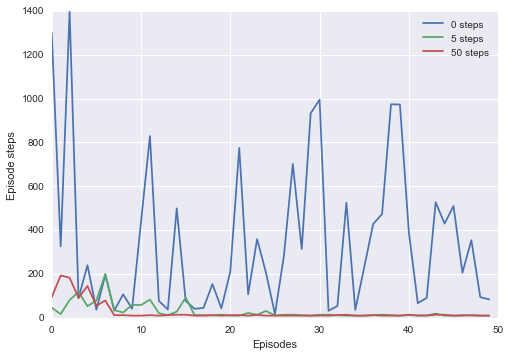

In [108]:
total_steps_0 = []
total_steps_5 = []
total_steps_50 = []
total_steps_0 = prioritized_sweeping(0)
print('Done With prioritized_sweeping 0')
total_steps_5 = prioritized_sweeping(5)
print('Done With prioritized_sweeping 5')
total_steps_50 = prioritized_sweeping(50)
print('Done With prioritized_sweeping 50')

plt.plot(range(NO_OF_EPISODES), total_steps_0, range(NO_OF_EPISODES), total_steps_5, range(NO_OF_EPISODES), total_steps_50)
plt.ylabel('Episode steps')
plt.xlabel('Episodes')
plt.legend(['0 steps', '5 steps', '50 steps'], loc='best')